tensorflow로 구현
- 최종레이어에 sigmoid가 없음
- cost가 크로스 엔트로피가 아니로 MSE
- 성능 측정시 정확도가 아니고 평균 오차 OR 결정 계수
- 그래프로 예측 결과 시각화

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv('./datasets/PRSA_data_2010.1.1-2014.12.31.csv')
df.shape

(43824, 13)

In [33]:
df = df.set_index('No')
df.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [34]:
df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

In [35]:
threshold = df['pm2.5'].mean() + df['pm2.5'].std()
threshold

188.4665103676712

In [37]:
df['y'] = (df['pm2.5'] > threshold).astype(np.int)

In [41]:
df = df.drop(columns=['year', 'day', 'hour'])
df['month'] = df['month'].astype(np.object)

In [42]:
##df_valid = df.iloc[:, 4:]

In [43]:
## df_dum = pd.get_dummies(df_valid)
df_dum = pd.get_dummies(df)
x = df_dum.iloc[:-24]
y = df_dum.iloc[24:]['pm2.5']
x.shape, y.shape
df_rolling = df_dum.rolling(window=24).mean().dropna()
x = df_rolling.iloc[:-24]
y = df_rolling.iloc[24:]['pm2.5']

In [44]:
x = np.array(x).astype(np.float32)
y = np.array(y).astype(np.float32).reshape([-1, 1])
x.shape, y.shape, np.min(y), np.max(y)

((43777, 24), (43777, 1), 2.9166667, 646.3333)

In [69]:
# sklearn으로 정규화
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [70]:
scaler_x = MinMaxScaler().fit(x)
scaler_y = MinMaxScaler().fit(y)
xn = scaler_x.transform(x)
yn = scaler_y.transform(y)
np.min(xn), np.max(xn), np.min(yn), np.max(yn)

(0.0, 1.0000001, 0.0, 0.99999994)

In [71]:
w1 = tf.Variable(tf.random_normal(shape=[24, 10])) ## x > hidden 784=28*28
b1 = tf.Variable(tf.random_normal(shape=[10]))
w2 = tf.Variable(tf.random_normal(shape=[10, 1])) ## hidden > h 
b2 = tf.Variable(tf.random_normal(shape=[1])) # 이진분류라서 1이라 했지만, 다중분류이면 k개 설정
## xn = x / tf.reduce_max(xn, -1, True)
h1 = tf.sigmoid(tf.matmul(xn, w1)+b1)
out = tf.matmul(h1, w2)+b2
cost = tf.reduce_mean((yn-out)**2)
train = tf.train.GradientDescentOptimizer(0.5).minimize(cost)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.cast(y, tf.int64), tf.arg_max(out, -1)), tf.float32))
sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [72]:
for i in range(1000):
    _, c, = sess.run([train, cost])
    if(i%100)==0: print(i, c, r2_score(yn, sess.run(out)))


0 0.6499575 -420.01006834810613
100 0.013477659 0.024294975173407507
200 0.013274377 0.0389392314013941
300 0.013133831 0.049090711096344886
400 0.013015019 0.05768531277332423
500 0.012901855 0.06587877323711155
600 0.0127860075 0.07427126515010685
700 0.01266216 0.08324611781269953
800 0.012526626 0.09306951780993877
900 0.012377264 0.10389487963577859


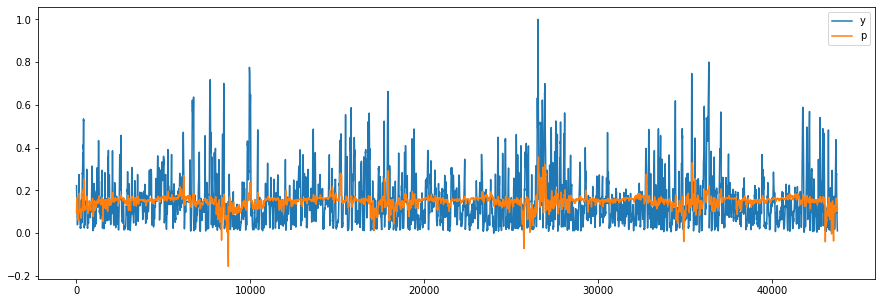

In [73]:
plt.figure(figsize=(15, 5))
plt.plot(yn, label='y')
plt.plot(sess.run(out), label='p')
plt.legend()

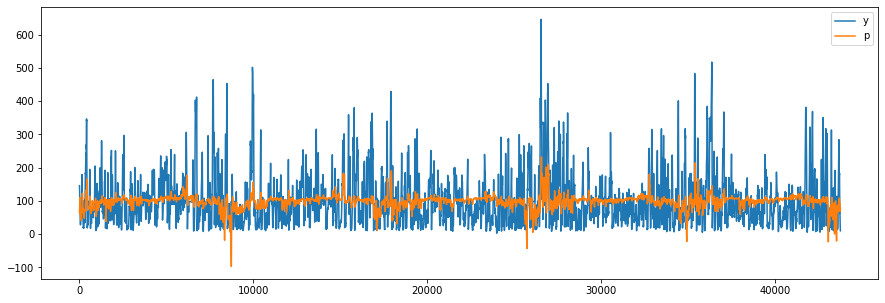

In [74]:
plt.figure(figsize=(15, 5))
plt.plot(scaler_y.inverse_transform(yn), label='y')
plt.plot(scaler_y.inverse_transform(sess.run(out)), label='p')
plt.legend()